In [2]:
import os
import random
import time
import copy
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageFilter
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, datasets
import timm

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.6


In [3]:
TRAIN_DIR = Path("data/train")
VAL_DIR = Path("data/validation")

# Training parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
FREEZE_EPOCHS = 3
LR = 3e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 5

# Model parameters
BACKBONE = "tf_efficientnet_b0_ns"
DROPOUT = 0.5
LABEL_SMOOTHING = 0.1
MIXUP_ALPHA = 0.2

# Paths for saving
MODEL_PATH_BEST = "best_model.pth"
MODEL_PATH_FINAL = "final_model.pth"

print("Configuration loaded successfully!")

Configuration loaded successfully!


Exploring dataset...

Classes found: ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis', 'blue_finger', 'clubbing', 'pitting']

✓ Total images: 3835
✓ Corrupted images: 0


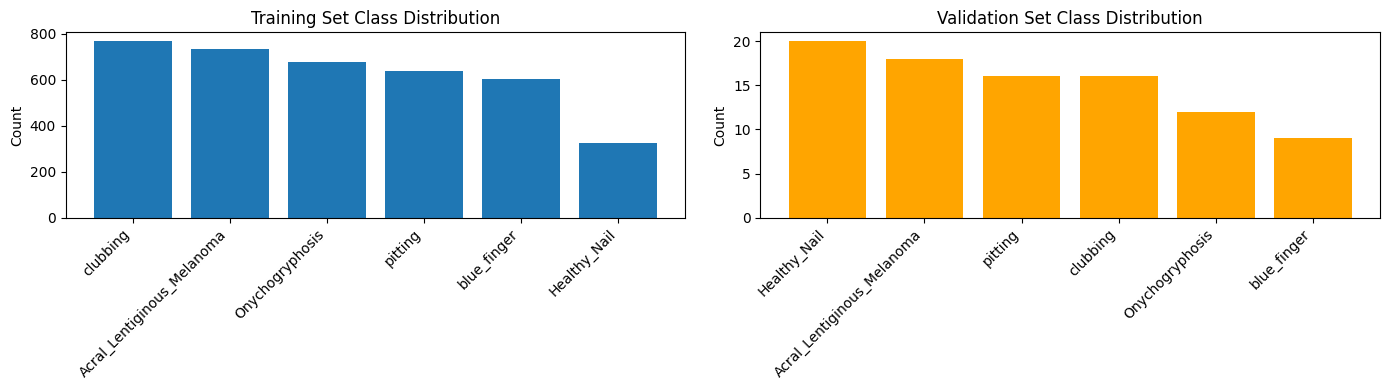


Class distribution:
class
clubbing                      767
Acral_Lentiginous_Melanoma    735
Onychogryphosis               677
pitting                       639
blue_finger                   603
Healthy_Nail                  323
Name: count, dtype: int64


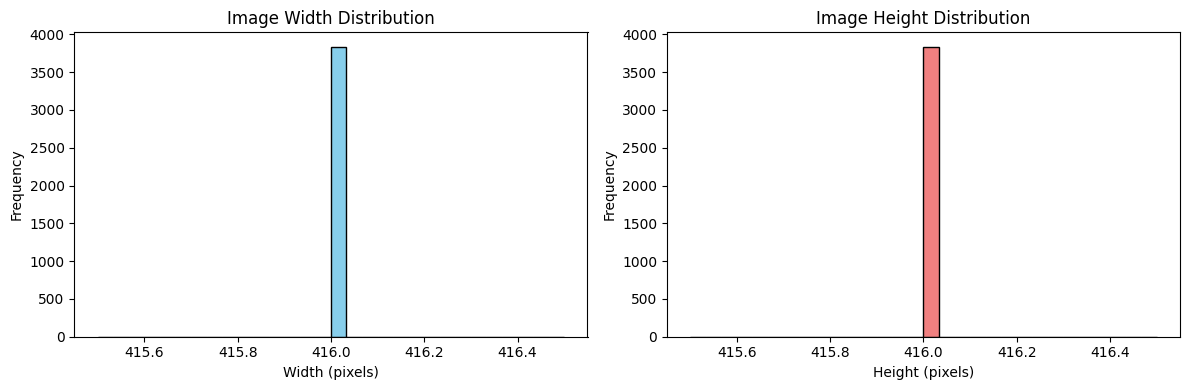

Width range: 416 - 416
Height range: 416 - 416


Analyzing brightness: 100%|██████████| 500/500 [00:00<00:00, 594.58it/s]


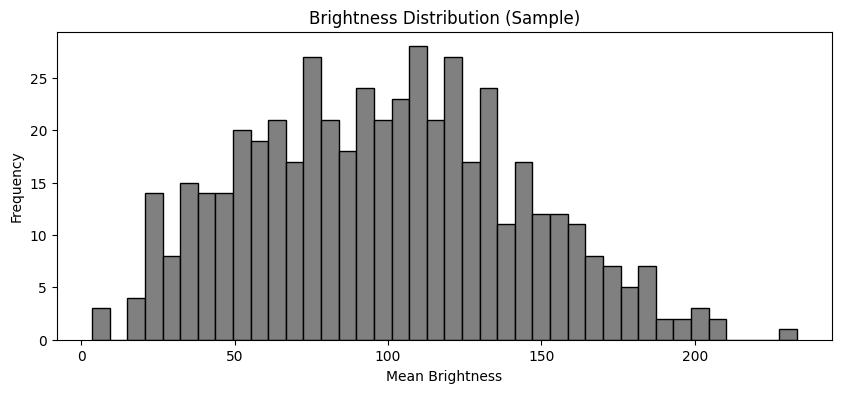

Mean brightness: 98.78
Std brightness: 43.70


In [4]:
def explore_dataset():
    """Validate images and create manifest"""
    print("Exploring dataset...")
    
    classes = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
    print(f"\nClasses found: {classes}")
    
    items = []
    errors = []
    sizes = []
    
    for split in ["train", "validation"]:
        split_dir = TRAIN_DIR if split == "train" else VAL_DIR
        
        for cls in classes:
            cls_dir = split_dir / cls
            if not cls_dir.exists():
                continue
                
            for p in cls_dir.iterdir():
                if p.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
                    continue
                
                try:
                    with Image.open(p) as img:
                        img.verify()
                    with Image.open(p) as img:
                        sizes.append(img.size)
                    items.append((str(p), cls, split))
                except Exception as e:
                    errors.append((str(p), str(e)))
    
    df = pd.DataFrame(items, columns=["path", "class", "split"])
    df.to_csv("manifest.csv", index=False)
    
    print(f"\n✓ Total images: {len(df)}")
    print(f"✓ Corrupted images: {len(errors)}")
    
    return df, classes, sizes

# Run exploration
df, classes, sizes = explore_dataset()

# %% [markdown]
# ### Class Distribution

# %%
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Training distribution
train_counts = df[df.split=='train']['class'].value_counts()
axes[0].bar(range(len(train_counts)), train_counts.values)
axes[0].set_xticks(range(len(train_counts)))
axes[0].set_xticklabels(train_counts.index, rotation=45, ha='right')
axes[0].set_title('Training Set Class Distribution')
axes[0].set_ylabel('Count')

# Validation distribution
val_counts = df[df.split=='validation']['class'].value_counts()
axes[1].bar(range(len(val_counts)), val_counts.values, color='orange')
axes[1].set_xticks(range(len(val_counts)))
axes[1].set_xticklabels(val_counts.index, rotation=45, ha='right')
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("\nClass distribution:")
print(train_counts)

# %% [markdown]
# ### Image Size Analysis

# %%
widths = [w for w, h in sizes]
heights = [h for w, h in sizes]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(widths, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Image Width Distribution')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')

axes[1].hist(heights, bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Image Height Distribution')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Width range: {min(widths)} - {max(widths)}")
print(f"Height range: {min(heights)} - {max(heights)}")

# %% [markdown]
# ### Brightness Analysis

# %%
brightness_vals = []

for path in tqdm(df["path"][:500], desc="Analyzing brightness"):  # Sample 500 images
    img = Image.open(path).convert("L")
    brightness_vals.append(np.array(img).mean())

plt.figure(figsize=(10, 4))
plt.hist(brightness_vals, bins=40, color='gray', edgecolor='black')
plt.title('Brightness Distribution (Sample)')
plt.xlabel('Mean Brightness')
plt.ylabel('Frequency')
plt.show()

print(f"Mean brightness: {np.mean(brightness_vals):.2f}")
print(f"Std brightness: {np.std(brightness_vals):.2f}")

Preprocessing functions defined!


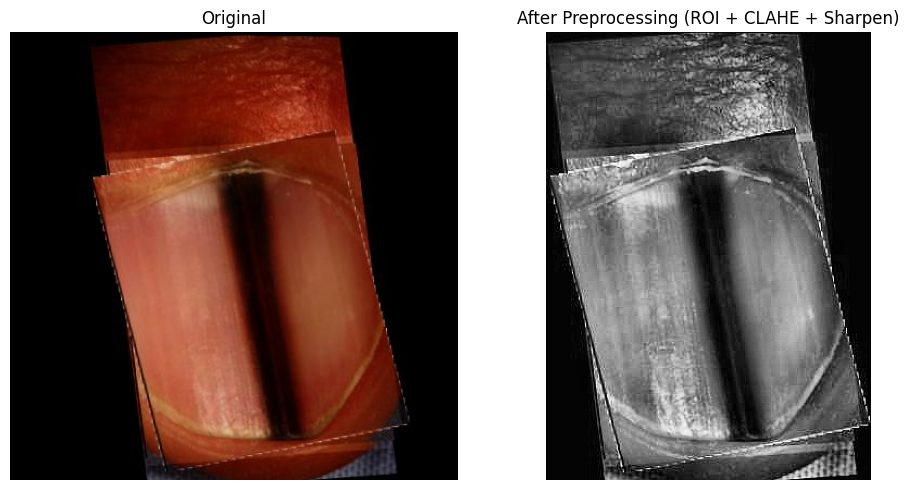

In [5]:
def extract_roi(img):
    """Auto-crop to non-black region"""
    arr = np.array(img.convert("L"))
    mask = arr > 10
    if mask.sum() == 0:
        return img
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    return img.crop((x0, y0, x1, y1))

def apply_clahe(img):
    """CLAHE for contrast enhancement"""
    img_arr = np.array(img.convert("L"))
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(img_arr)
    return Image.fromarray(enhanced).convert("RGB")

def sharpen(img):
    """Sharpen image"""
    return img.filter(ImageFilter.SHARPEN)

class Preprocess:
    """Custom preprocessing pipeline"""
    def __call__(self, img):
        img = extract_roi(img)
        img = apply_clahe(img)
        img = sharpen(img)
        return img

print("Preprocessing functions defined!")

# %% [markdown]
# ### Test Preprocessing

# %%
# Show before/after preprocessing
sample_path = df.iloc[0]['path']
sample_img = Image.open(sample_path).convert("RGB")

preprocessor = Preprocess()
processed_img = preprocessor(sample_img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_img)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(processed_img)
axes[1].set_title('After Preprocessing (ROI + CLAHE + Sharpen)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


Data augmentation pipelines created!

✓ Train images: 3744
✓ Val images: 91
✓ Classes: ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis', 'blue_finger', 'clubbing', 'pitting']
✓ Number of classes: 6


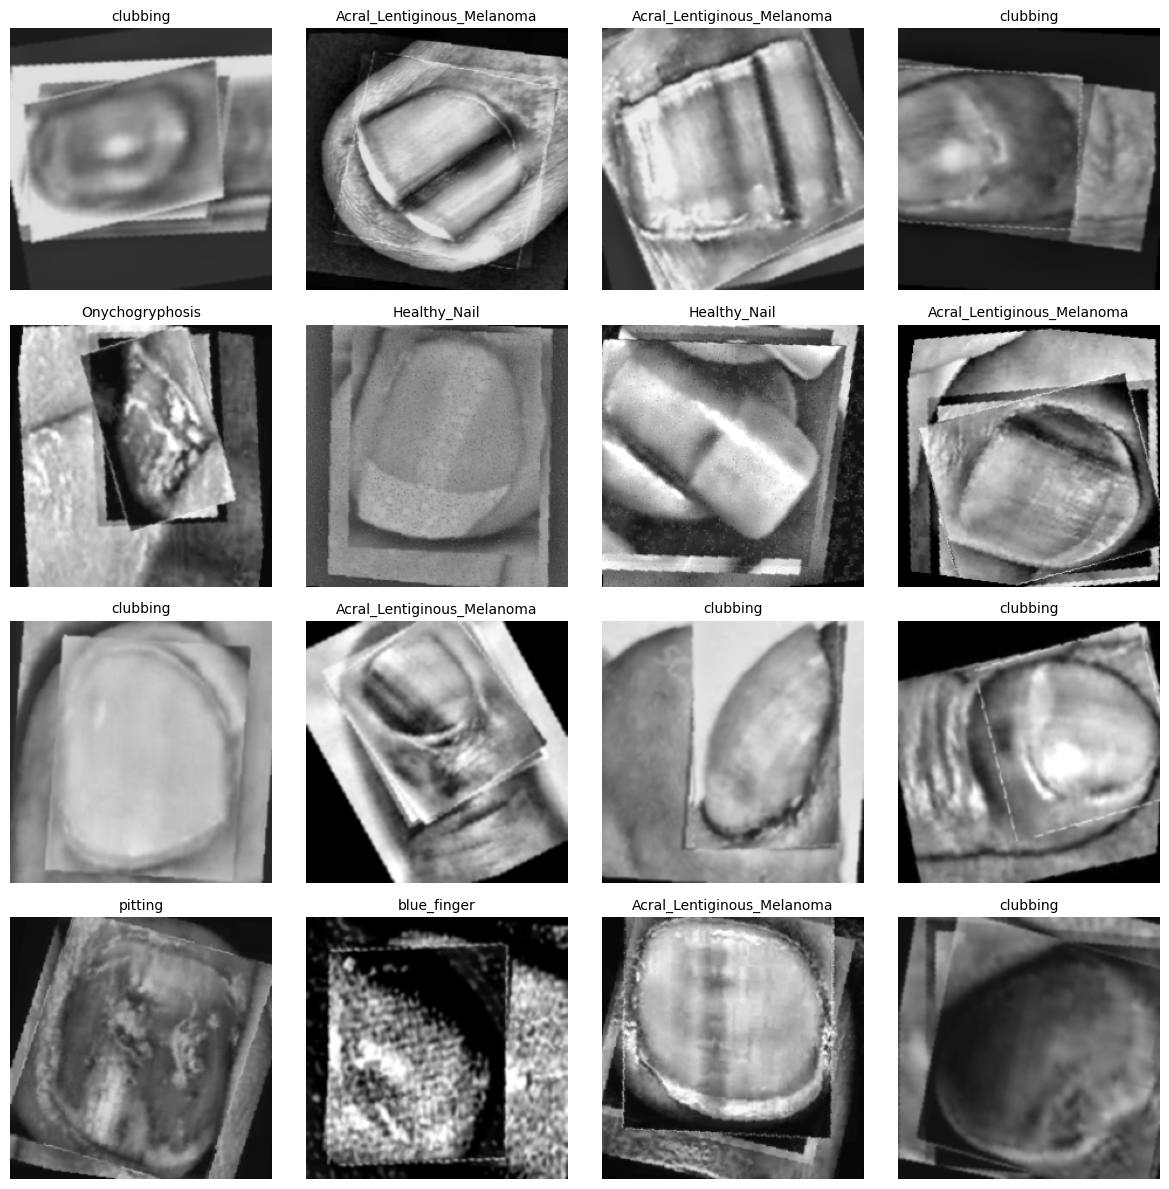

In [6]:
train_tfms = transforms.Compose([
    Preprocess(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(12),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.1),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.80, 1.0)),
    transforms.ColorJitter(0.25, 0.25, 0.25, 0.05),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation transforms (no augmentation)
val_tfms = transforms.Compose([
    Preprocess(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Data augmentation pipelines created!")

# %%
# Create datasets
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds = datasets.ImageFolder(VAL_DIR, transform=val_tfms)

# Balanced sampler for class imbalance
targets = torch.tensor([label for _, label in train_ds.samples])
class_counts = torch.bincount(targets)
class_weights = 1.0 / class_counts.float()
sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create dataloaders
train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    sampler=sampler, 
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

print(f"\n✓ Train images: {len(train_ds)}")
print(f"✓ Val images: {len(val_ds)}")
print(f"✓ Classes: {train_ds.classes}")
print(f"✓ Number of classes: {len(train_ds.classes)}")

# %% [markdown]
# ### Visualize Augmented Samples

# %%
def show_samples(dataset, n_samples=16):
    """Show random samples from dataset"""
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for ax in axes.flat:
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        
        # Denormalize for visualization
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(dataset.classes[label], fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_ds)

In [7]:
class NailDiseaseClassifier(nn.Module):
    """Custom classifier with dropout and regularization"""
    def __init__(self, backbone_name, num_classes, dropout=0.5):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=True,
            drop_rate=dropout,
            drop_path_rate=0.2
        )
        
        # Replace classifier head
        if hasattr(self.backbone, 'classifier'):
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(in_features, num_classes)
            )
        elif hasattr(self.backbone, 'fc'):
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(in_features, num_classes)
            )
    
    def forward(self, x):
        return self.backbone(x)

# Create model
model = NailDiseaseClassifier(
    backbone_name=BACKBONE,
    num_classes=len(train_ds.classes),
    dropout=DROPOUT
).to(DEVICE)

print(f"Model: {BACKBONE}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


d:\projects\cuda\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


Model: tf_efficientnet_b0_ns
Total parameters: 4,015,234
Trainable parameters: 4,015,234


In [8]:
def mixup_data(x, y, alpha=0.2):
    """MixUp augmentation"""
    if alpha <= 0:
        return x, y, None, None, 1.0
    
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, index, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """MixUp loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print("MixUp functions defined!")

# %% [markdown]
# ## 8. Training & Validation Functions

# %%
def train_one_epoch(model, loader, criterion, optimizer, scaler, use_mixup=True):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    loop = tqdm(loader, desc="Training", leave=False)
    for imgs, labels in loop:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Apply MixUp
        if use_mixup and MIXUP_ALPHA > 0:
            mixed_imgs, labels_a, labels_b, _, lam = mixup_data(imgs, labels, MIXUP_ALPHA)
            
            with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
                outputs = model(mixed_imgs)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        # Metrics
        running_loss += loss.item() * imgs.size(0)
        batch_preds = outputs.argmax(1).cpu().numpy()
        all_preds.append(batch_preds)
        all_targets.append(labels.cpu().numpy())
        
        loop.set_postfix(loss=f"{loss.item():.4f}")
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_targets, all_preds)
    epoch_f1 = f1_score(all_targets, all_preds, average="macro")
    
    return epoch_loss, epoch_acc, epoch_f1

def validate(model, loader, criterion):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * imgs.size(0)
            batch_preds = outputs.argmax(1).cpu().numpy()
            all_preds.append(batch_preds)
            all_targets.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    val_loss = running_loss / len(loader.dataset)
    val_acc = accuracy_score(all_targets, all_preds)
    val_f1 = f1_score(all_targets, all_preds, average="macro")
    cm = confusion_matrix(all_targets, all_preds)
    
    return val_loss, val_acc, val_f1, cm, all_preds, all_targets

print("Training and validation functions defined!")

MixUp functions defined!
Training and validation functions defined!


In [9]:
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

# Freeze backbone initially
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.backbone.classifier.parameters():
    param.requires_grad = True

print(f"✓ Backbone frozen for first {FREEZE_EPOCHS} epochs")
print("✓ Training setup complete!")

# %%
print("\n" + "="*60)
print("TRAINING STARTED")
print("="*60 + "\n")

# Training state
best_f1 = 0.0
best_weights = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

history = {
    "train_loss": [], "train_acc": [], "train_f1": [],
    "val_loss": [], "val_acc": [], "val_f1": []
}

# Training loop
for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")
    
    # Unfreeze after warmup
    if epoch == FREEZE_EPOCHS:
        print("🔓 Unfreezing backbone...")
        for param in model.backbone.parameters():
            param.requires_grad = True
        # Reduce learning rate
        for g in optimizer.param_groups:
            g['lr'] = LR * 0.1
        print(f"Learning rate reduced to {LR * 0.1}")
    
    # Train
    use_mixup = (epoch >= FREEZE_EPOCHS)
    train_loss, train_acc, train_f1 = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler, use_mixup
    )
    
    # Validate
    val_loss, val_acc, val_f1, cm, preds, targets = validate(
        model, val_loader, criterion
    )
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_f1"].append(train_f1)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)
    
    # Print results
    print(f"\nTrain Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
    print(f"\nConfusion Matrix:\n{cm}")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_weights = copy.deepcopy(model.state_dict())
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'val_f1': val_f1,
            'classes': train_ds.classes
        }, MODEL_PATH_BEST)
        print(f"\n✔ Saved best model (F1 = {val_f1:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"\nNo improvement ({epochs_no_improve}/{PATIENCE})")
    
    # Early stopping
    if epoch >= FREEZE_EPOCHS and epochs_no_improve >= PATIENCE:
        print("\n⏹ Early stopping triggered!")
        break

# Load best weights
model.load_state_dict(best_weights)
torch.save(model.state_dict(), MODEL_PATH_FINAL)

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"\nBest Validation F1: {best_f1:.4f}")

C:\Users\HP\AppData\Local\Temp\ipykernel_3676\701479420.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))


✓ Backbone frozen for first 3 epochs
✓ Training setup complete!

TRAINING STARTED


Epoch 1/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 1.7179 | Acc: 0.2879 | F1: 0.2794
Val   Loss: 1.6139 | Acc: 0.5055 | F1: 0.4122

Confusion Matrix:
[[ 5  8  2  1  0  2]
 [ 0 20  0  0  0  0]
 [ 4  1  6  0  1  0]
 [ 5  0  0  0  4  0]
 [ 2  2  0  0 11  1]
 [ 0  0 10  0  2  4]]

✔ Saved best model (F1 = 0.4122)

Epoch 2/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 1.5768 | Acc: 0.4471 | F1: 0.4334
Val   Loss: 1.5185 | Acc: 0.5495 | F1: 0.4610

Confusion Matrix:
[[ 3  9  2  1  0  3]
 [ 0 20  0  0  0  0]
 [ 1  0  8  0  0  3]
 [ 2  0  0  1  6  0]
 [ 0  0  1  0 14  1]
 [ 0  0 10  0  2  4]]

✔ Saved best model (F1 = 0.4610)

Epoch 3/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 1.5174 | Acc: 0.4637 | F1: 0.4532
Val   Loss: 1.4573 | Acc: 0.5824 | F1: 0.5111

Confusion Matrix:
[[ 7  7  2  0  0  2]
 [ 1 19  0  0  0  0]
 [ 1  0  5  0  0  6]
 [ 3  0  0  1  5  0]
 [ 0  0  0  2 13  1]
 [ 0  0  6  0  2  8]]

✔ Saved best model (F1 = 0.5111)

Epoch 4/20
🔓 Unfreezing backbone...
Learning rate reduced to 2.9999999999999997e-05


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 1.4288 | Acc: 0.3817 | F1: 0.3730
Val   Loss: 1.2099 | Acc: 0.6813 | F1: 0.6512

Confusion Matrix:
[[ 9  6  3  0  0  0]
 [ 0 20  0  0  0  0]
 [ 3  0  7  0  0  2]
 [ 3  0  0  4  2  0]
 [ 0  0  0  2 10  4]
 [ 0  0  4  0  0 12]]

✔ Saved best model (F1 = 0.6512)

Epoch 5/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 1.3225 | Acc: 0.3878 | F1: 0.3846
Val   Loss: 1.0669 | Acc: 0.7692 | F1: 0.7495

Confusion Matrix:
[[11  5  2  0  0  0]
 [ 0 20  0  0  0  0]
 [ 3  0  7  0  0  2]
 [ 2  0  0  6  1  0]
 [ 0  0  0  2 11  3]
 [ 0  0  1  0  0 15]]

✔ Saved best model (F1 = 0.7495)

Epoch 6/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 1.0598 | Acc: 0.4212 | F1: 0.4211
Val   Loss: 0.6620 | Acc: 0.8901 | F1: 0.8714

Confusion Matrix:
[[18  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 3  0  8  1  0  0]
 [ 0  0  0  9  0  0]
 [ 1  0  0  3 10  2]
 [ 0  0  0  0  0 16]]

✔ Saved best model (F1 = 0.8714)

Epoch 7/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.9292 | Acc: 0.4714 | F1: 0.4715
Val   Loss: 0.6639 | Acc: 0.9121 | F1: 0.9083

Confusion Matrix:
[[14  0  0  0  0  4]
 [ 0 20  0  0  0  0]
 [ 0  0 11  0  0  1]
 [ 0  0  0  9  0  0]
 [ 0  0  0  3 13  0]
 [ 0  0  0  0  0 16]]

✔ Saved best model (F1 = 0.9083)

Epoch 8/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.8549 | Acc: 0.5887 | F1: 0.5891
Val   Loss: 0.5706 | Acc: 0.9011 | F1: 0.8830

Confusion Matrix:
[[17  0  0  0  0  1]
 [ 0 20  0  0  0  0]
 [ 0  0 11  0  1  0]
 [ 0  0  0  6  3  0]
 [ 0  0  0  2 12  2]
 [ 0  0  0  0  0 16]]

No improvement (1/5)

Epoch 9/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.8700 | Acc: 0.5064 | F1: 0.5062
Val   Loss: 0.6113 | Acc: 0.9011 | F1: 0.8856

Confusion Matrix:
[[16  0  0  0  0  2]
 [ 0 20  0  0  0  0]
 [ 2  0  9  0  1  0]
 [ 0  0  0  7  2  0]
 [ 0  0  0  2 14  0]
 [ 0  0  0  0  0 16]]

No improvement (2/5)

Epoch 10/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.8304 | Acc: 0.5505 | F1: 0.5507
Val   Loss: 0.5257 | Acc: 0.9451 | F1: 0.9413

Confusion Matrix:
[[16  0  0  0  0  2]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  8  1  0]
 [ 0  0  0  1 14  1]
 [ 0  0  0  0  0 16]]

✔ Saved best model (F1 = 0.9413)

Epoch 11/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.8089 | Acc: 0.5596 | F1: 0.5595
Val   Loss: 0.5320 | Acc: 0.9670 | F1: 0.9655

Confusion Matrix:
[[16  0  0  0  0  2]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  8  1  0]
 [ 0  0  0  0 16  0]
 [ 0  0  0  0  0 16]]

✔ Saved best model (F1 = 0.9655)

Epoch 12/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.7716 | Acc: 0.5267 | F1: 0.5262
Val   Loss: 0.5303 | Acc: 0.9451 | F1: 0.9426

Confusion Matrix:
[[15  0  0  0  0  3]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  1  0  8  0  0]
 [ 0  0  0  1 15  0]
 [ 0  0  0  0  0 16]]

No improvement (1/5)

Epoch 13/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.7575 | Acc: 0.6341 | F1: 0.6340
Val   Loss: 0.5094 | Acc: 0.9890 | F1: 0.9902

Confusion Matrix:
[[17  0  0  0  0  1]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  0 16  0]
 [ 0  0  0  0  0 16]]

✔ Saved best model (F1 = 0.9902)

Epoch 14/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.7682 | Acc: 0.5574 | F1: 0.5567
Val   Loss: 0.5128 | Acc: 0.9780 | F1: 0.9804

Confusion Matrix:
[[16  0  0  0  0  2]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  0 16  0]
 [ 0  0  0  0  0 16]]

No improvement (1/5)

Epoch 15/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.7140 | Acc: 0.5962 | F1: 0.5959
Val   Loss: 0.5140 | Acc: 0.9560 | F1: 0.9564

Confusion Matrix:
[[15  0  0  0  0  3]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  1 15  0]
 [ 0  0  0  0  0 16]]

No improvement (2/5)

Epoch 16/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.8184 | Acc: 0.5657 | F1: 0.5658
Val   Loss: 0.6288 | Acc: 0.9121 | F1: 0.9003

Confusion Matrix:
[[16  0  0  0  0  2]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  6 10  0]
 [ 0  0  0  0  0 16]]

No improvement (3/5)

Epoch 17/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.8133 | Acc: 0.6114 | F1: 0.6120
Val   Loss: 0.5103 | Acc: 0.9670 | F1: 0.9706

Confusion Matrix:
[[15  0  0  0  0  3]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  0 16  0]
 [ 0  0  0  0  0 16]]

No improvement (4/5)

Epoch 18/20


Training:   0%|          | 0/117 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):



Train Loss: 0.7458 | Acc: 0.5657 | F1: 0.5659
Val   Loss: 0.5217 | Acc: 0.9560 | F1: 0.9564

Confusion Matrix:
[[15  0  0  0  0  3]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  1 15  0]
 [ 0  0  0  0  0 16]]

No improvement (5/5)

⏹ Early stopping triggered!

TRAINING COMPLETE

Best Validation F1: 0.9902


In [10]:
val_loss, val_acc, val_f1, cm, preds, targets = validate(model, val_loader, criterion)

print("="*60)
print("FINAL VALIDATION RESULTS")
print("="*60)
print(f"\nLoss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"Macro F1: {val_f1:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(targets, preds, target_names=train_ds.classes))


C:\Users\HP\AppData\Local\Temp\ipykernel_3676\3273530317.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):


FINAL VALIDATION RESULTS

Loss: 0.5094
Accuracy: 0.9890
Macro F1: 0.9902

Confusion Matrix:
[[17  0  0  0  0  1]
 [ 0 20  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  0 16  0]
 [ 0  0  0  0  0 16]]

CLASSIFICATION REPORT
                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       1.00      0.94      0.97        18
              Healthy_Nail       1.00      1.00      1.00        20
           Onychogryphosis       1.00      1.00      1.00        12
               blue_finger       1.00      1.00      1.00         9
                  clubbing       1.00      1.00      1.00        16
                   pitting       0.94      1.00      0.97        16

                  accuracy                           0.99        91
                 macro avg       0.99      0.99      0.99        91
              weighted avg       0.99      0.99      0.99        91



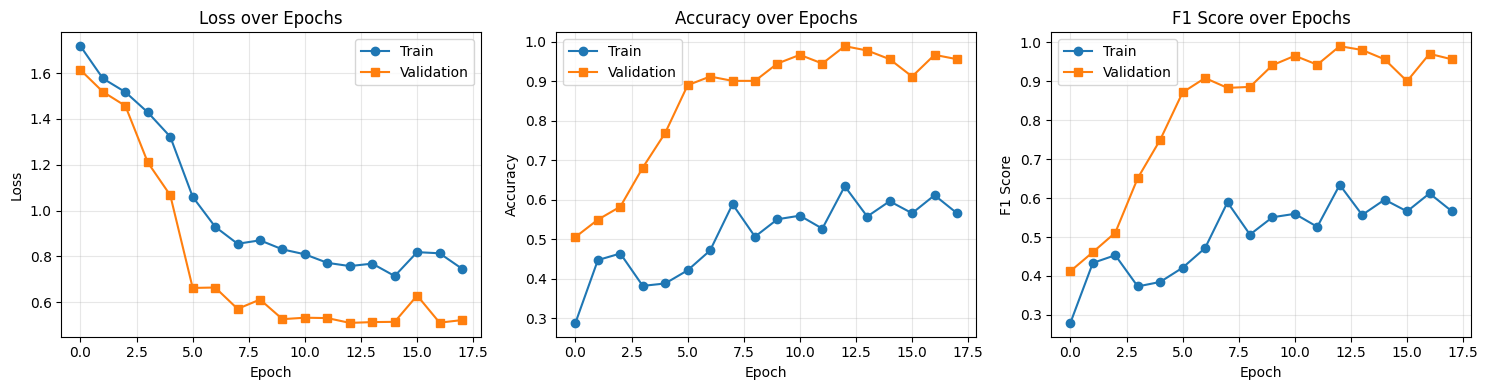

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Validation', marker='s')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train', marker='o')
axes[1].plot(history['val_acc'], label='Validation', marker='s')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(history['train_f1'], label='Train', marker='o')
axes[2].plot(history['val_f1'], label='Validation', marker='s')
axes[2].set_title('F1 Score over Epochs')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

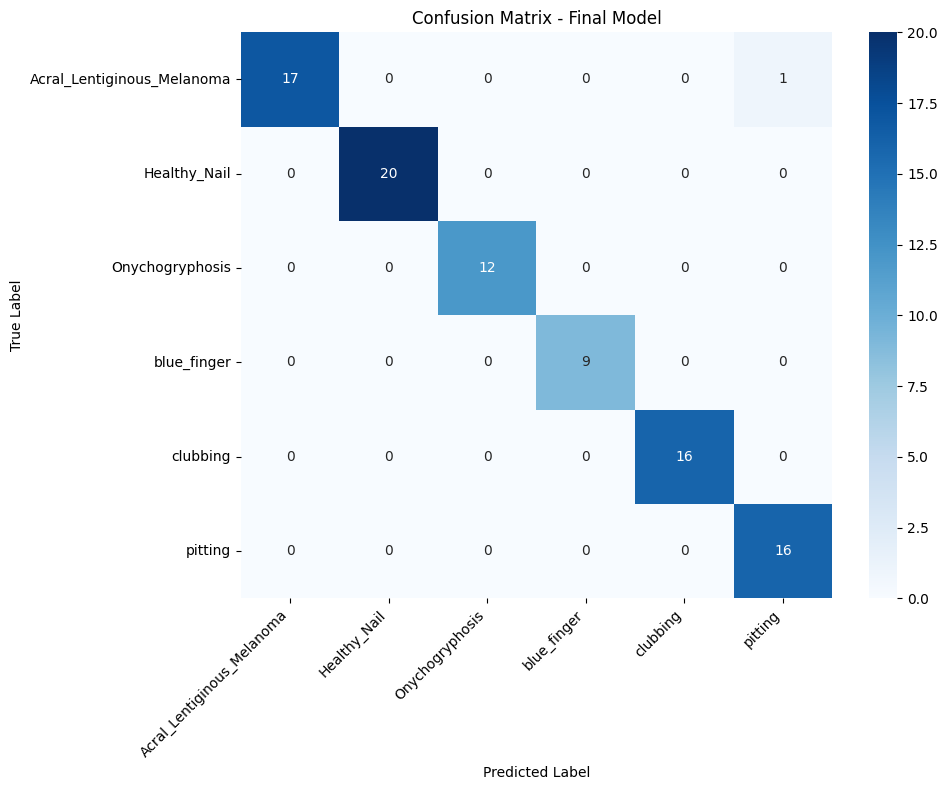

In [12]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_ds.classes, 
            yticklabels=train_ds.classes)
plt.title('Confusion Matrix - Final Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [13]:
def predict_image(model, image_path, classes):
    """Predict single image"""
    # Preprocessing
    preprocess = transforms.Compose([
        Preprocess(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Load and preprocess
    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
    
    # Predict
    model.eval()
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
            outputs = model(img_tensor)
            probs = torch.softmax(outputs, dim=1)
            pred_idx = torch.argmax(probs, dim=1).item()
            confidence = probs[0][pred_idx].item()
    
    return classes[pred_idx], confidence, probs[0].cpu().numpy()

print("Inference function defined!")

Inference function defined!


C:\Users\HP\AppData\Local\Temp\ipykernel_3676\544192357.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):


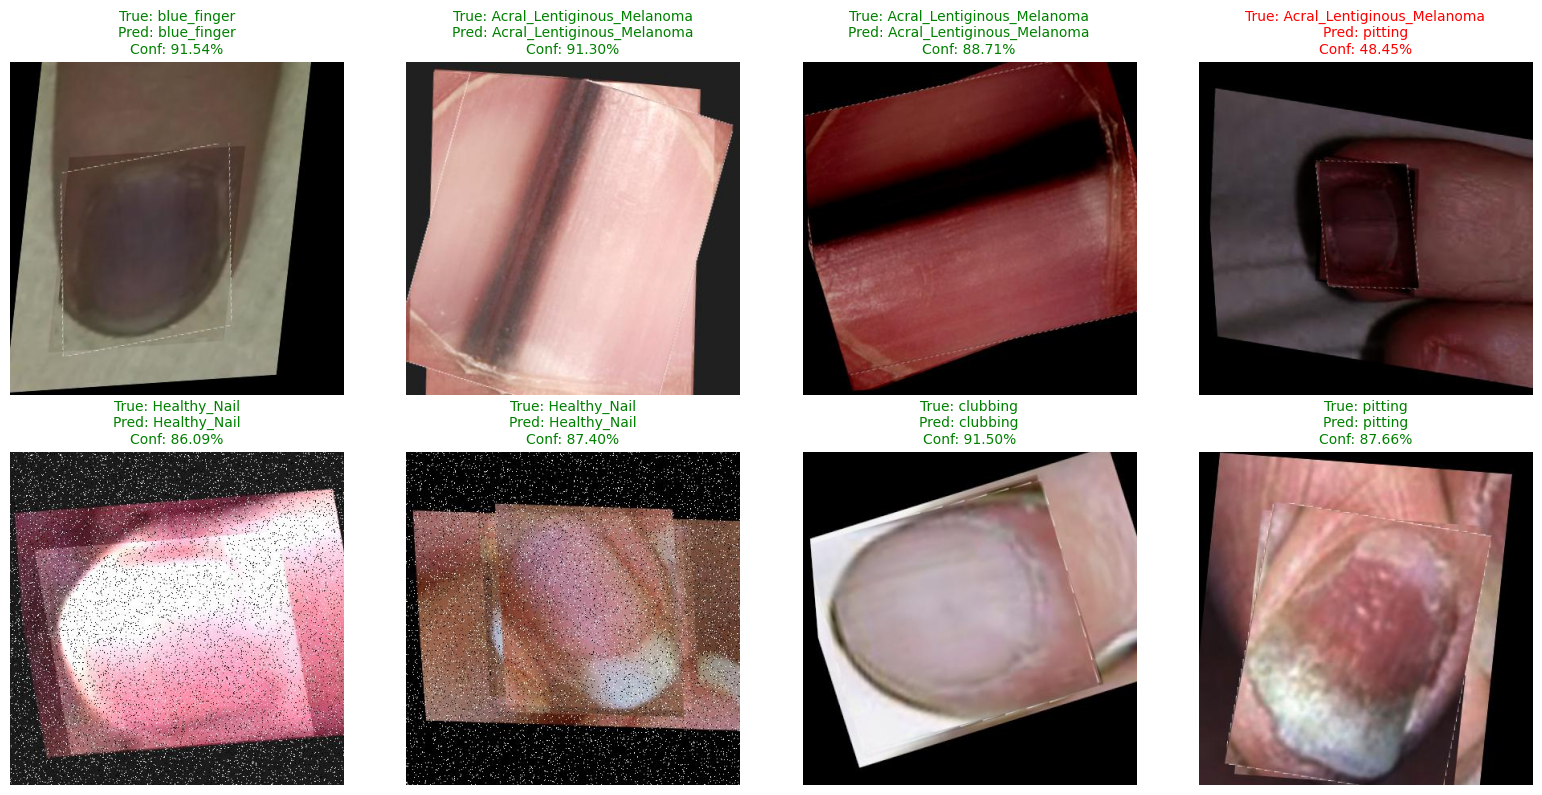

In [14]:
sample_indices = random.sample(range(len(val_ds)), 8)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    img_path, true_label = val_ds.samples[sample_idx]
    
    # Predict
    pred_class, confidence, all_probs = predict_image(model, img_path, train_ds.classes)
    true_class = train_ds.classes[true_label]
    
    # Display
    img = Image.open(img_path).convert("RGB")
    axes[idx].imshow(img)
    
    # Color code: green if correct, red if wrong
    color = 'green' if pred_class == true_class else 'red'
    axes[idx].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2%}', 
                        color=color, fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('inference_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
def load_model(model_path):
    """Load trained model"""
    checkpoint = torch.load(model_path, map_location=DEVICE)
    
    # Get classes
    classes = checkpoint['classes']
    
    # Create model
    model = NailDiseaseClassifier(
        backbone_name=BACKBONE,
        num_classes=len(classes),
        dropout=DROPOUT
    ).to(DEVICE)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✓ Model loaded from {model_path}")
    print(f"✓ Validation F1: {checkpoint['val_f1']:.4f}")
    print(f"✓ Classes: {classes}")
    
    return model, classes

# Example usage:
# loaded_model, loaded_classes = load_model(MODEL_PATH_BEST)
# pred_class, confidence, probs = predict_image(loaded_model, "path/to/image.jpg", loaded_classes)

print("Model loading function defined!")

Model loading function defined!


In [16]:
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\n✓ Model: {BACKBONE}")
print(f"✓ Total epochs: {len(history['train_loss'])}")
print(f"✓ Best validation F1: {best_f1:.4f}")
print(f"✓ Final validation accuracy: {val_acc:.4f}")
print(f"✓ Number of classes: {len(train_ds.classes)}")
print(f"✓ Training samples: {len(train_ds)}")
print(f"✓ Validation samples: {len(val_ds)}")
print(f"\n✓ Best model saved to: {MODEL_PATH_BEST}")
print(f"✓ Final model saved to: {MODEL_PATH_FINAL}")
print("\n" + "="*60)
print("Pipeline complete! Model ready for deployment.")
print("="*60)

TRAINING SUMMARY

✓ Model: tf_efficientnet_b0_ns
✓ Total epochs: 18
✓ Best validation F1: 0.9902
✓ Final validation accuracy: 0.9890
✓ Number of classes: 6
✓ Training samples: 3744
✓ Validation samples: 91

✓ Best model saved to: best_model.pth
✓ Final model saved to: final_model.pth

Pipeline complete! Model ready for deployment.
